In [22]:
#%pip install wbdata
from __future__ import annotations
import time
from functools import lru_cache
from typing import Literal
import wbdata
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt


# 1. Population DataFrames [A]

### Helper Functions

In [3]:
#Helper Functions

Sex = Literal["female", "male", "total"]

AGE_BINS_5Y = [
    "0004","0509","1014","1519","2024","2529","3034","3539",
    "4044","4549","5054","5559","6064","6569","7074","7579","80UP"
]

BIN_TO_RANGE = {
    "0004": (0,4),   "0509": (5,9),   "1014": (10,14), "1519": (15,19),
    "2024": (20,24), "2529": (25,29), "3034": (30,34), "3539": (35,39),
    "4044": (40,44), "4549": (45,49), "5054": (50,54), "5559": (55,59),
    "6064": (60,64), "6569": (65,69), "7074": (70,74), "7579": (75,79),
    "80UP": (80,200),
}

def bins_for_age_range(start_age: int, end_age: int) -> list[str]:
    ''' >>> bins_for_age_range(start_age = 0, end_age = 9)
        return: ['0004', '0509']
        '''
    return [b for b,(lo,hi) in BIN_TO_RANGE.items() if not (hi < start_age or lo > end_age)]

def wb_indicator_5y(age_code: str, sex: str) -> str:
    ''' This helper constructs variable indicator.
    >>> wb_indicator_5y(age_code = '0004', sex = 'female')
    output: "SP.POP.0004.FE"
    '''
    
    sex_code = "FE" if sex == "female" else "MA"
    return f"SP.POP.{age_code}.{sex_code}"

Below is validation helper functions

In [8]:
def _validate_years(years: tuple[int, int]) -> None:
    if (not isinstance(years, tuple)) or len(years) != 2:
        raise TypeError("years must be a tuple of (start_year, end_year)")
    y0, y1 = years
    if not (isinstance(y0, int) and isinstance(y1, int)):
        raise TypeError("years must contain integers")
    if y0 > y1:
        raise ValueError("years must satisfy start_year <= end_year")
    if y0 < 1960 or y1 > 2024:
        raise ValueError("years must be between 1960 and 2024, inclusive")


def _validate_area(area: str) -> str:
    if not isinstance(area, str):
        raise TypeError("area must be a string")
    area = area.strip()
    if not area:
        raise ValueError("area must be a non-empty string")
    return area


def _validate_sex(sex: str) -> Sex:
    if not isinstance(sex, str):
        raise TypeError("sex must be a string")
    sex = sex.strip().lower()
    if sex not in ("female", "male", "total"):
        raise ValueError("sex must be 'female', 'male', or 'total'")
    return sex  # type: ignore[return-value]


def _validate_age_range(age_range: tuple[int, int]) -> tuple[int, int]:
    if (not isinstance(age_range, tuple)) or len(age_range) != 2:
        raise TypeError("age_range must be a tuple (low, high)")
    low, high = age_range
    if not (isinstance(low, int) and isinstance(high, int)):
        raise TypeError("age_range bounds must be integers")
    if low < 0 or high < 0:
        raise ValueError("age_range bounds must be non-negative")
    if low > high:
        raise ValueError("age_range must satisfy low <= high")

    # Exact 5-year boundary validation:
    # valid ranges are unions of 5-year bins, so:
    #   low must be multiple of 5
    #   high must be 4 mod 5
    if (low % 5) != 0 or (high % 5) != 4:
        raise ValueError(
            "age_range must align to 5-year bins, e.g. (0,4), (0,9), (5,14), (15,19)"
        )

    # Optional: enforce max bound if your bins top out (e.g., 100+)
    # You can skip this if AGE_BINS_5Y already handles it robustly.
    return low, high



### Below is the main population DataFrame function.

In [14]:
@lru_cache(maxsize=128)
def population_df(years: tuple[int, int], area: str, chunk: int = 4) -> pd.DataFrame:
    """
    Example: india_pop_df = population_df(years=(2018, 2020), area="India")
    Returns a DataFrame with male and female counts of each 5-year age range.
    Please enter a year between 1960 and 2024. 
    """
    _validate_years(years)
    area = _validate_area(area)
    if not isinstance(chunk, int) or chunk <= 0:
        raise ValueError("chunk must be a positive integer")

    # Resolve country id (kept inside cached function; caching avoids repeat lookups too)
    countries = wbdata.get_countries(query=f"^{re.escape(area)}$")
    if not countries:
        raise ValueError(f"No country matched area={area!r}")
    country_id = countries[0]["id"]

    def fetch(sub_bins: list[str]) -> pd.DataFrame:
        indicators: dict[str, str] = {}
        for b in sub_bins:
            indicators[wb_indicator_5y(b, "female")] = f"female_{b}"
            indicators[wb_indicator_5y(b, "male")] = f"male_{b}"

        last_err: Exception | None = None
        for k in range(5):
            try:
                # Note: skip_cache=True means "do not use wbdata's cache".
                # Our lru_cache handles caching at the function level.
                return wbdata.get_dataframe(
                    indicators,
                    country=country_id,
                    parse_dates=True,
                    skip_cache=True,
                )
            except Exception as e:
                last_err = e
                time.sleep(0.5 * (2 ** k))
        assert last_err is not None
        raise last_err

    parts: list[pd.DataFrame] = []
    for i in range(0, len(AGE_BINS_5Y), chunk):
        parts.append(fetch(AGE_BINS_5Y[i : i + chunk]))

    df = pd.concat(parts, axis=1)

    # Ensure datetime-like index
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index.astype(str), errors="coerce")

    y0, y1 = years
    df = df[(df.index.year >= y0) & (df.index.year <= y1)]

    # Consistent column order: female bins then male bins
    df = df[[f"female_{b}" for b in AGE_BINS_5Y] + [f"male_{b}" for b in AGE_BINS_5Y]]

    df.index = df.index.year
    return df


## Example usage: India, Pakistan, Bangladesh

In [10]:
india_pop_df = population_df(
    years=(2018, 2020),
    area="India"
)
india_pop_df

,female_0004,female_0509,female_1014,female_1519,female_2024,female_2529,female_3034,female_3539,female_4044,female_4549,...,male_3539,male_4044,male_4549,male_5054,male_5559,male_6064,male_6569,male_7074,male_7579,male_80UP
date,,,,,,,,,,,,,,,,,,,,,
2020,56846872.0,58963120.0,60665244.0,62395896.0,60243689.0,57840211.0,54935788.0,49741493.0,43638105.0,38698224.0,...,53887018.0,46734880.0,40676622.0,34948447.0,29842077.0,24391302.0,18414252.0,11412174.0,6763527.0,6022397.0
2019,57282565.0,59639765.0,60964654.0,62398981.0,59826923.0,57450398.0,54201524.0,48603778.0,42701924.0,37828159.0,...,52655474.0,45655208.0,39720245.0,34265392.0,29253476.0,23856378.0,17744267.0,10729139.0,6563601.0,5848977.0
2018,57658903.0,60182984.0,61358955.0,62178615.0,59493195.0,57071892.0,53371842.0,47428167.0,41890672.0,36968547.0,...,51357720.0,44714951.0,38790269.0,33606373.0,28617405.0,23257654.0,16881262.0,10184368.0,6369273.0,5610832.0


In [17]:
pakistan_pop_df = population_df(
    years=(2018, 2020),
    area="Pakistan"
)
pakistan_pop_df

,female_0004,female_0509,female_1014,female_1519,female_2024,female_2529,female_3034,female_3539,female_4044,female_4549,...,male_3539,male_4044,male_4549,male_5054,male_5559,male_6064,male_6569,male_7074,male_7579,male_80UP
date,,,,,,,,,,,,,,,,,,,,,
2020,15135723.0,14747268.0,13509747.0,11953769.0,10589322.0,9178292.0,7971028.0,6781031.0,5462580.0,4592609.0,...,7054881.0,5649523.0,4693000.0,3995869.0,3405482.0,2673615.0,1849839.0,1258424.0,815695.0,549314.0
2019,15066334.0,14672234.0,13106103.0,11842307.0,10352470.0,9023735.0,7802118.0,6561813.0,5299620.0,4479068.0,...,6820015.0,5482969.0,4580573.0,3935368.0,3339937.0,2585977.0,1768110.0,1273822.0,798298.0,543553.0
2018,15033611.0,14527510.0,12767698.0,11709909.0,10184029.0,8904215.0,7656495.0,6346200.0,5163603.0,4379673.0,...,6594647.0,5341148.0,4484313.0,3878315.0,3265730.0,2490220.0,1694365.0,1279654.0,775608.0,530510.0


In [19]:
bangladesh_pop_df = population_df(
    years=(2018, 2020),
    area="Bangladesh"
)
bangladesh_pop_df

,female_0004,female_0509,female_1014,female_1519,female_2024,female_2529,female_3034,female_3539,female_4044,female_4549,...,male_3539,male_4044,male_4549,male_5054,male_5559,male_6064,male_6569,male_7074,male_7579,male_80UP
date,,,,,,,,,,,,,,,,,,,,,
2020,7746950.0,7613840.0,8284906.0,8748000.0,8402872.0,7450277.0,6732030.0,6308133.0,4948399.0,4316810.0,...,5835444.0,4805839.0,4052711.0,3501273.0,3030756.0,2523977.0,1916516.0,1299119.0,844722.0,631202.0
2019,7672802.0,7652839.0,8400369.0,8709213.0,8198837.0,7211497.0,6758736.0,6097405.0,5009833.0,4325774.0,...,5600201.0,4648536.0,3975248.0,3461014.0,3005075.0,2473877.0,1824725.0,1279477.0,809215.0,593632.0
2018,7614705.0,7722231.0,8490530.0,8649599.0,7930168.0,7084157.0,6717282.0,5971400.0,5084278.0,4303487.0,...,5369942.0,4533173.0,3898406.0,3427467.0,2974856.0,2406654.0,1724425.0,1255624.0,768982.0,551648.0


# 2. Population Statistics [A]

This functio answers the question: In [year] how many [people/males/females] aged [low] to [high] were living in [the world/region/country]?

In [17]:
def population_stats(
    year: int,
    sex: str,
    age_range: tuple[int, int],
    area: str,
) -> int:
    """
    Returns the population count as an integer.
    For variable sex, please enter 'female, 'male', or 'total'.
    Age range should also follow five the head and tail of 5-year range
    ex. 0-4, 5-9, 5-14, 15-29 

    Example:
    pakistan_pop_stats = population_stats(year= 2000, 
                     sex= 'total', 
                     age_range= (15, 29), 
                     area= 'Pakistan')
    output: 41045700
    """
    if not isinstance(year, int):
        raise TypeError("year must be an int")
    if year < 1960 or year > 2024:
        raise ValueError("year must be between 1960 and 2024")

    sex_v = _validate_sex(sex)
    low, high = _validate_age_range(age_range)
    area = _validate_area(area)

    df = population_df((year, year), area)
    if df.empty:
        raise ValueError(f"No data returned for {area!r} in {year}")

    row = df.iloc[0]
    bins = bins_for_age_range(low, high)

    if sex_v == "female":
        count = sum(row[f"female_{b}"] for b in bins)
    elif sex_v == "male":
        count = sum(row[f"male_{b}"] for b in bins)
    else:  # total
        count = sum(row[f"female_{b}"] + row[f"male_{b}"] for b in bins)

    # Be robust to floats/NaNs coming back from wbdata
    if pd.isna(count):
        raise ValueError("Population count is NaN (missing data for one or more bins)")
    return int(count)


def format_population_stats_sentence(
    year: int,
    sex: str,
    age_range: tuple[int, int],
    area: str,
) -> str:
    """
    This returns the wrapper that produces the sentence: 
    In [year] how many [people/males/females] aged [low] to [high] 
    were living in [the world/region/country]?

    """
    sex_v = _validate_sex(sex)
    low, high = _validate_age_range(age_range)
    area = _validate_area(area)

    count = population_stats(year, sex_v, (low, high), area)

    who = {"female": "females", "male": "males", "total": "people"}[sex_v]
    return f"In {year}, there were {count:,} {who} aged {low} to {high} living in {area}."


In [12]:
india_pop_stats = format_population_stats_sentence(year= 2000, 
                     sex= 'female', 
                     age_range= (15, 29), 
                     area= 'India')
india_pop_stats

'In 2000, there were 139,428,253 females aged 15 to 29 living in India.'

In [16]:
pakistan_pop_stats = format_population_stats_sentence(year= 2000, 
                     sex= 'total', 
                     age_range= (15, 29), 
                     area= 'Pakistan')
pakistan_pop_stats

'In 2000, there were 41,045,700 people aged 15 to 29 living in Pakistan.'

# Studying India v.s Bangladesh v.s Pakistan Pre- and Post- Liberation War

## Population Growth Rate
First we want to visualize population growth rate

In [19]:
def population_growth_rate(years,country):
    
    def country_id(country):
        single_country = wbdata.get_countries(query=f"^{re.escape(country)}$")
        return single_country[0]["id"]

    country_id = country_id(country)
    indicators = {"SP.POP.GROW" : "Population growth (annual %)"}

    country_df = wbdata.get_dataframe(indicators, country = country_id, parse_dates = True)

    start, end = years
    growth_adjusted = country_df[(country_df.index.year >= start) & (country_df.index.year <= end)]

    return growth_adjusted.rename(columns = lambda c: country if c == growth_adjusted.columns[0] else c)
    

rate_BGD = population_growth_rate([1961, 1980], "Bangladesh")
rate_IND = population_growth_rate([1961, 1980], "India")
rate_PAK = population_growth_rate([1961, 1980], "Pakistan")


In [21]:
pop_growth_rate = rate_BGD.join([rate_IND, rate_PAK])
pop_growth_rate.head()

,Bangladesh,India,Pakistan
date,,,
1980-01-01,2.393149,2.384826,4.085150
1979-01-01,2.408973,2.325480,3.464073
1978-01-01,2.440310,2.302730,3.203209
1977-01-01,2.488273,2.358940,3.135964
1976-01-01,2.537669,2.352628,3.060995


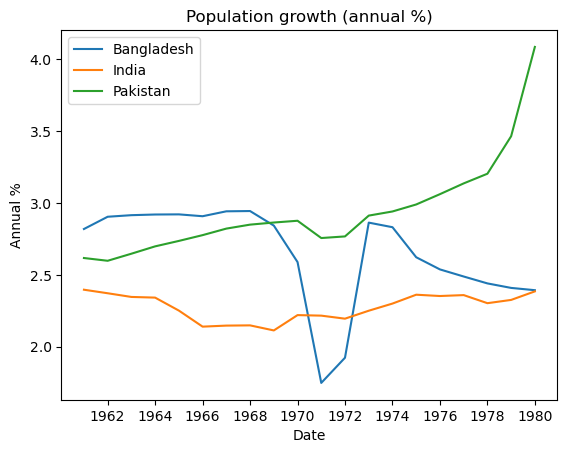

In [23]:

plt.plot(pop_growth_rate, label = pop_growth_rate.columns )
plt.ylabel("Annual %")
plt.xlabel("Date")
plt.title("Population growth (annual %)")
plt.legend()

### Population growth rate = Birth-Death+Immigration.
The graph clearly shows a major dip around 1971 for Bangladesh where many either died or fled to India, as India was located in between the now Bangladesh and Pakistan. 